<a href="https://colab.research.google.com/github/ferdinand-popp/MEDS-Detection/blob/main/Hackathon_notebook_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal of this notebook is to classify wrong diagnoses to ensure data quality.

The notebook is structured as follows:

1) Data

1a) Data Basics (Read in data, cleaning)

1b) Data Exploration (Overview variables, distributions of interesting variables, correlation plot)

1c) Feature Engineering

2) Model

3) Evaluation 




# 0) Imports


In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, datetime
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import random
from sklearn.preprocessing import OneHotEncoder
import numpy as np


import statsmodels.api as sm
from scipy.io import arff

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel, RFE
#from imblearn.over_sampling import RandomOverSampler, SMOTE

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. Data

## a) Data Basics

In [135]:
# read in data
path = r'./gdrive/MyDrive/Hackathon/Data/csv 1000/'

patientsDF = pd.read_csv(path + "patients.csv", sep=';')
careplansDF= pd.read_csv(path + "careplans.csv", sep=";")
encountersDF= pd.read_csv(path + "encounters.csv", sep=";")
medicationsDF= pd.read_csv(path + "medications.csv", sep=";")


In [136]:
# general inspection
patientsDF

,Id,BIRTHDATE,DEATHDATE,RACE,ETHNICITY,GENDER,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,9fedb279-262a-0c53-f492-32187aef6790,2020-10-15,NaN,white,nonhispanic,F,4.170.413.601.741.240,-7.089.549.216.918.610,25.264.697.500.000.000,26.690.924.999.999.900
1,4fa083ee-cbc8-0375-40ec-ad7ccad1c6b0,2021-06-29,NaN,white,hispanic,F,42.429.405.553.483.700,-7.156.239.083.645.270,9008.67,0.0
2,b3fae15c-08b7-8bb6-834e-773aa2602c8f,1981-11-30,NaN,other,nonhispanic,M,4.245.436.340.147.450,-7.102.399.195.874.750,10.183.040.375.000.000,163.559.025
3,f54d52f1-05ca-c0da-bcfe-d1d53df105e8,1977-05-06,NaN,white,nonhispanic,F,4.204.790.290.548.330,-7.070.889.608.289.330,15.454.890.009.999.900,12.321.389.789.999.900
4,58b1e070-397c-0002-7304-0cbd55c03e6e,1994-06-23,NaN,white,nonhispanic,F,4.238.415.474.074.480,-7.114.120.034.354.770,14.277.719.845,37.456.861.549.999.900
...,...,...,...,...,...,...,...,...,...,...
1143,ea5105be-6238-51b7-c4ee-8b6e0e9c394f,1970-08-06,NaN,asian,nonhispanic,M,4.237.263.714.827.380,-7.109.255.494.339.590,9.290.775.674.999.990,62.648.625
1144,56f5710a-398f-4791-1c84-2787508d076c,1986-09-27,NaN,white,nonhispanic,F,4.170.143.358.645.440,-7.106.891.494.421.640,8.430.503.805.000.000,5.165.554.294.999.990
1145,c04e2562-938a-4aea-47b9-91f570d46fed,1923-03-20,2010-10-24,white,nonhispanic,M,4.236.228.503.939.260,-7.127.483.165.021.970,24.448.919.955,24.458.167.245.000.000
1146,f5f0451c-e3fd-8c31-68dd-0987f55650c7,1923-03-20,1989-03-12,white,nonhispanic,M,42.360.455.574.656.900,-7.125.753.368.990.860,16.761.742.049.999.900,14.369.935


In [137]:
 careplansDF.head()

,Id,START,STOP,PATIENT,ENCOUNTER,CODE,REASONCODE
0,e829a7db-6738-0ab3-2b30-16a87558e060,1993-12-20,NaN,b3fae15c-08b7-8bb6-834e-773aa2602c8f,9285b8f3-901f-765e-eaa8-b362ed6ec46e,718361005,NaN
1,99b8af2f-c887-990c-3511-802dc2ad189e,2014-04-01,2014-04-15,b3fae15c-08b7-8bb6-834e-773aa2602c8f,7eb068ea-fc37-9c47-17fa-5d33f416d7db,225358003,370247008
2,6597f66c-802b-140c-0607-3381e947c607,2002-07-12,NaN,f54d52f1-05ca-c0da-bcfe-d1d53df105e8,74769ac9-ceb1-8c49-7658-34215ea1fefd,698360004,15777000
3,83cbb58f-0eb0-1996-93d4-93076afb7c5b,2012-07-20,2013-02-22,f54d52f1-05ca-c0da-bcfe-d1d53df105e8,1794e942-f6dd-7cec-781b-77ff3f678f52,134435003,72892002
4,14b13470-52df-2ab4-ce89-d3d7f8dda2c5,2013-05-01,2013-05-15,f54d52f1-05ca-c0da-bcfe-d1d53df105e8,4e9640e3-5488-0fca-7c2b-bdde742f9f41,737471002,NaN


In [138]:
encountersDF.head()

,Id,START,STOP,PATIENT,CODE,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST
0,753370ed-5855-0eb1-3ac8-52394a404ef7,2021-06-29T09:30:38Z,2021-06-29T09:45:38Z,4fa083ee-cbc8-0375-40ec-ad7ccad1c6b0,410620009,129.16,269.68
1,4f789064-7fd0-1d8b-53c1-f17b543f7154,2020-10-15T16:34:49Z,2020-10-15T16:49:49Z,9fedb279-262a-0c53-f492-32187aef6790,410620009,129.16,1017.22
2,ed700002-1246-2f52-f79a-e09924e7eaef,2021-08-03T09:30:38Z,2021-08-03T09:45:38Z,4fa083ee-cbc8-0375-40ec-ad7ccad1c6b0,410620009,129.16,269.68
3,257337a1-ff17-a943-b5ab-b3399db896d1,2020-11-19T16:34:49Z,2020-11-19T16:49:49Z,9fedb279-262a-0c53-f492-32187aef6790,410620009,129.16,269.68
4,0866f60f-8ca3-3e65-776d-4964a5d86044,2021-01-21T16:34:49Z,2021-01-21T16:49:49Z,9fedb279-262a-0c53-f492-32187aef6790,410620009,129.16,1376.72


In [139]:
medicationsDF.head()

,START,STOP,PATIENT,ENCOUNTER,CODE,REASONCODE
0,2011-10-20T04:40:35Z,2011-11-13T04:40:35Z,b3fae15c-08b7-8bb6-834e-773aa2602c8f,db159278-74e8-06fc-3e75-842aaa1455cb,562251,444814009
1,2021-10-10T16:34:49Z,NaN,9fedb279-262a-0c53-f492-32187aef6790,66e90df2-c8e2-1083-b0a0-a81d2b91b508,198405,NaN
2,2014-04-01T01:23:00Z,2014-04-15T01:23:00Z,b3fae15c-08b7-8bb6-834e-773aa2602c8f,7eb068ea-fc37-9c47-17fa-5d33f416d7db,849574,NaN
3,2018-01-18T08:40:35Z,2018-02-05T08:40:35Z,b3fae15c-08b7-8bb6-834e-773aa2602c8f,ebce6168-26ce-1437-b2f5-0451bfd1f63f,562251,444814009
4,2000-10-27T02:35:25Z,NaN,f54d52f1-05ca-c0da-bcfe-d1d53df105e8,aa59b9b2-320f-2b9e-417a-97206bf6fac3,310325,NaN


In [140]:
df = patientsDF.merge(encountersDF, left_on='Id', right_on='PATIENT', how='inner')
df = df.drop(columns=['Id_x'])
df = df.merge(medicationsDF, left_on =['Id_y', 'PATIENT'], right_on=['ENCOUNTER', 'PATIENT'], how='left')
df = df.merge(careplansDF, left_on=['Id_y', 'PATIENT'], right_on=['ENCOUNTER', 'PATIENT'], how='left')
df = df.drop(columns=["HEALTHCARE_EXPENSES", "HEALTHCARE_COVERAGE", "Id_y", "PATIENT", "BASE_ENCOUNTER_COST", "ENCOUNTER_x", "Id", "ENCOUNTER_y"], axis=1)
df.head()

,BIRTHDATE,DEATHDATE,RACE,ETHNICITY,GENDER,LAT,LON,START_x,STOP_x,CODE_x,TOTAL_CLAIM_COST,START_y,STOP_y,CODE_y,REASONCODE_x,START,STOP,CODE,REASONCODE_y
0,2020-10-15,NaN,white,nonhispanic,F,4.170.413.601.741.240,-7.089.549.216.918.610,2020-10-15T16:34:49Z,2020-10-15T16:49:49Z,410620009,1017.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-15,NaN,white,nonhispanic,F,4.170.413.601.741.240,-7.089.549.216.918.610,2020-11-19T16:34:49Z,2020-11-19T16:49:49Z,410620009,269.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-10-15,NaN,white,nonhispanic,F,4.170.413.601.741.240,-7.089.549.216.918.610,2021-01-21T16:34:49Z,2021-01-21T16:49:49Z,410620009,1376.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-10-15,NaN,white,nonhispanic,F,4.170.413.601.741.240,-7.089.549.216.918.610,2021-03-25T16:34:49Z,2021-03-25T16:49:49Z,410620009,831.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-10-15,NaN,white,nonhispanic,F,4.170.413.601.741.240,-7.089.549.216.918.610,2021-06-24T16:34:49Z,2021-06-24T16:49:49Z,410620009,831.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
#rename columns
df = df.rename(columns={"STOP":"Stop Treatment", "REASONCODE_y": "Reasoncode_Careplan", "START":"Start Treatment", "CODE_x":"Diagnosis", "REASONCODE_x":"Reasoncode_Medication", "STOP_y":"Stop Careplan", "CODE":"Careplan", "START_y":"Start Careplan", "CODE_y":"Medication", "START_x":"Start Medication", "STOP_x":"Stop Medication"})

In [142]:
def age(medStart, born):
    #born = datetime.strptime(born, "%d/%m/%Y").date()
    #today = date.today()
    return medStart.year - born.year - ((medStart.month, 
                                      medStart.day) < (born.month, 
                                                    born.day))

In [143]:
df['BIRTHDATE']= pd.to_datetime(df['BIRTHDATE'])
df['Start Medication'] = pd.to_datetime(df['Start Medication'])
df.dtypes

df['Age'] = df.apply(lambda x: age(x['Start Medication'], x['BIRTHDATE']), axis=1)
#df['Age'] = df['BIRTHDATE'].apply(age)
#df = df.drop(columns=["BIRTHDATE"])

In [144]:
def isDead(dDate):
  if pd.isna(dDate):
    return 0
  else:
    return 1  

In [145]:
df['Dead'] = df['DEATHDATE'].apply(isDead)
df = df.drop(columns=['DEATHDATE'])

In [146]:
def difference(dayOne, dayTwo):
    return (dayOne - dayTwo).dt.days

In [147]:

df['Stop Medication'] = pd.to_datetime(df['Stop Medication'])
df['Start Careplan'] = pd.to_datetime(df['Start Careplan'])
df['Stop Careplan'] = pd.to_datetime(df['Stop Careplan'])
df['Start Treatment'] = pd.to_datetime(df['Start Treatment'])
df['Stop Treatment'] = pd.to_datetime(df['Stop Treatment'])


df['Careplan length'] = (df['Stop Careplan'] - df['Start Careplan']).dt.days
df = df.drop(columns=['Start Medication', 'Stop Medication', 'Start Careplan', 'Stop Careplan', 'Start Treatment', 'Stop Treatment'])

In [148]:
df = df.drop(columns=['LON', 'LAT'])

In [149]:
df.dtypes

BIRTHDATE                datetime64[ns]
RACE                             object
ETHNICITY                        object
GENDER                           object
Diagnosis                         int64
TOTAL_CLAIM_COST                float64
Medication                      float64
Reasoncode_Medication            object
Careplan                         object
Reasoncode_Careplan              object
Age                               int64
Dead                              int64
Careplan length                 float64
dtype: object

In [150]:
# missings
df.isna().sum().sort_values(ascending=False) / len(df)

Reasoncode_Careplan      0.955579
Careplan                 0.948678
Reasoncode_Medication    0.526333
Careplan length          0.405712
Medication               0.377053
Dead                     0.000000
Age                      0.000000
TOTAL_CLAIM_COST         0.000000
Diagnosis                0.000000
GENDER                   0.000000
ETHNICITY                0.000000
RACE                     0.000000
BIRTHDATE                0.000000
dtype: float64

## b) Data Exploration

In [151]:
# plot distributions of interesting variables

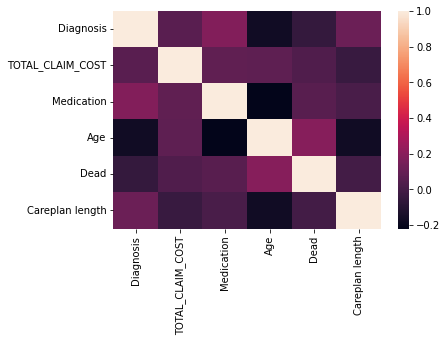

In [152]:
# plot correlations and kick non-necessary out


corr = df.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [153]:
# plot outliers
df

,BIRTHDATE,RACE,ETHNICITY,GENDER,Diagnosis,TOTAL_CLAIM_COST,Medication,Reasoncode_Medication,Careplan,Reasoncode_Careplan,Age,Dead,Careplan length
0,2020-10-15,white,nonhispanic,F,410620009,1017.22,NaN,NaN,NaN,NaN,0,0,NaN
1,2020-10-15,white,nonhispanic,F,410620009,269.68,NaN,NaN,NaN,NaN,0,0,NaN
2,2020-10-15,white,nonhispanic,F,410620009,1376.72,NaN,NaN,NaN,NaN,0,0,NaN
3,2020-10-15,white,nonhispanic,F,410620009,831.76,NaN,NaN,NaN,NaN,0,0,NaN
4,2020-10-15,white,nonhispanic,F,410620009,831.76,NaN,NaN,NaN,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90717,1923-03-20,white,nonhispanic,M,162673000,786.33,312961.0,NaN,NaN,NaN,97,0,NaN
90718,1923-03-20,white,nonhispanic,M,162673000,786.33,197361.0,NaN,NaN,NaN,97,0,NaN
90719,1923-03-20,white,nonhispanic,M,33879002,269.68,NaN,NaN,NaN,NaN,97,0,NaN
90720,1923-03-20,white,nonhispanic,M,33879002,269.68,NaN,NaN,NaN,NaN,98,0,NaN


## c) Feature Engineering & Prep

In [154]:
df2 = df[['RACE', 'ETHNICITY', 'GENDER',  'Diagnosis', 'TOTAL_CLAIM_COST', 'Age', 'Dead', 'Medication']]
df2.isna().sum().sort_values(ascending=False) / len(df)

Medication          0.377053
Dead                0.000000
Age                 0.000000
TOTAL_CLAIM_COST    0.000000
Diagnosis           0.000000
GENDER              0.000000
ETHNICITY           0.000000
RACE                0.000000
dtype: float64

In [155]:
# Inserting Noise
#split dataset into real 0 and fake 1
X_train, X_test, _, _ = train_test_split(df2, [0]*len(df2), test_size=0.1)
real = pd.DataFrame(X_train) #.cols
fake = pd.DataFrame(X_test) #.cols
real.columns = df2.columns
fake.columns = df2.columns

print(len(fake))
print(len(real))

9073
81649


In [156]:
diagnosis_old = fake.pop('Diagnosis')
old = diagnosis_old.to_list()
new = old 
random.shuffle(new)

#check if changed
fake_slots = []
for p, a in zip(new, diagnosis_old.to_list()):
  fake_slots.append(0 if (p==a) else 1)
fake['is_fake'] = fake_slots
fake['Diagnosis'] = new

In [157]:
#function permute
def permute_df(fake):
  #split fake df into smaller parts
  group_size = round(len(fake)/20)
  lst = [fake.iloc[i:i+group_size] for i in range(0,len(fake)-group_size+1,group_size)]
  #for each part permute in one column
  return_df = pd.DataFrame()
  for df in lst:
    possible_mutate = ['Diagnosis']#['Medication',  'Careplan',  'Reasoncode_Medication',  'Reasoncode_Careplan', 'Diagnosis']
    pick_one = random.choice(possible_mutate)
    old = df[pick_one].to_list()
    was = df[pick_one].to_list()
    #distribution
    #was.plot.hist(grid=True)
    random.shuffle(was)
    df[pick_one] = was
    #check if changed
    fake_slots = []
    for p, a in zip(was, old):
      fake_slots.append(0 if (p==a) else 1)
    df['is_fake'] = fake_slots
    if return_df.empty: 
      return_df = df 
    else:
      return_df.append(df)
  #return all appended permuted dfs as one
  return return_df
#print(fake)
#permuted_fake = permute_df(fake)
#print(permuted_fake)
real['is_fake'] = 0
complete_df = real.append(fake)

In [158]:
#split labels off
X = complete_df.iloc[:,:-1]
y = complete_df['is_fake']

# scaling
scaler = MinMaxScaler()
X[['TOTAL_CLAIM_COST', 'Age']] = scaler.fit_transform(X[['TOTAL_CLAIM_COST', 'Age']])

# one hot encoding
TOTAL_CLAIM_COST = X.pop('TOTAL_CLAIM_COST')
Age = X.pop('Age')
X['Medication'] = X['Medication'].replace(np.nan, 0)

enc = OneHotEncoder(categories='auto')

In [159]:
print('faked share:', (y.sum() / len(y)))

faked share: 0.08064196115605916


In [160]:
enc_df = pd.DataFrame(enc.fit_transform(X[['RACE', 'ETHNICITY', 'GENDER', 'Diagnosis', 'Medication']]).toarray())
enc_df.columns = enc.get_feature_names()
X = enc_df.drop(columns = ['x1_nonhispanic', 'x2_M'])

feature_list = list(X.columns)

#combine non_enc and encoded X
#X = pd.concat([enc_df, TOTAL_CLAIM_COST, Age], ignore_index=True)
X['Total Cost'] = TOTAL_CLAIM_COST.to_list()
X['Age'] = Age.to_list()

In [161]:
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [162]:
# oversampling / undersampling
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler(sampling_strategy='minority')

X_train, y_train = oversample.fit_resample(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [163]:
# feature selection (& correlation plot)
#X.isna().sum().sort_values(ascending=False) / len(X)

# 2. Model

In [164]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)

In [165]:
# grid search set up
#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', None]}
#param_grid = {'C': [ 0.01, 1, 10, 1000, 10000]}
#clf = GridSearchCV(LogisticRegression(max_iter = 1500), param_grid, cv=5, refit=True, scoring='roc_auc')

In [166]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

# 3. Evaluation

In [167]:
#clf.best_score_
#clf.best_params_

In [168]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, precision_score, recall_score
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[14554,  2128],
       [  195,  1268]])

In [169]:
recall_score(y_test, y_pred)

0.8667122351332878

In [ ]:
# Get numerical feature importances
importances = list(clf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

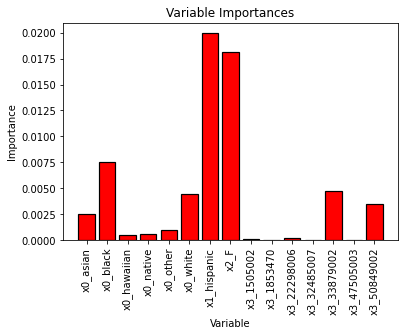

In [171]:
# list of x locations for plotting
importances_top = importances[:15]
x_values = list(range(len(importances_top)))# Make a bar chart
plt.bar(x_values, importances_top, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');